In [1]:
import os
import glob
import dqva
import random
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import qiskit
from qiskit import *
from qiskit.quantum_info import Statevector

from utils.graph_funcs import *
from utils.helper_funcs import *

from ansatz import qaoa, dqv_ansatz, qls_ansatz, dqv_cut_ansatz

matplotlib.rc('xtick', labelsize=13)     
matplotlib.rc('ytick', labelsize=13)
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
qiskit.__version__

'0.17.1'

In [9]:
circ = QuantumCircuit(3)
circ.h([0,1,2])
circ.save_statevector()
print(circ.draw())

simulator = Aer.get_backend('aer_simulator')
result = simulator.run(circ).result()
result.get_statevector(circ)

     ┌───┐ ░ 
q_0: ┤ H ├─░─
     ├───┤ ░ 
q_1: ┤ H ├─░─
     ├───┤ ░ 
q_2: ┤ H ├─░─
     └───┘ ░ 


array([0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j,
       0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j])

In [24]:
test_graphs = glob.glob('benchmark_graphs/N14_p20_graphs/*')
test_graphs = sorted(test_graphs, key=lambda g: int(g.split('/')[-1].strip('G.txt')))
print(len(test_graphs))

25


benchmark_graphs/N14_p20_graphs/G1.txt
Optimal: ('00000100111111', 7)


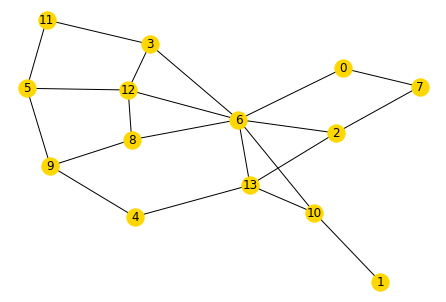

In [25]:
graph = test_graphs[0]
print(graph)
G = graph_from_file(graph)
print('Optimal:', brute_force_search(G))
nx.draw_spring(G, with_labels=True, node_color='gold')

# Test ansatz generation
## Quantum Alternating Operator Ansatz (QAOA)

In [39]:
nq = len(G.nodes())
P = 2
params = list(range(1, 2*P + 1))
mixer_order = list(range(nq))
#random.shuffle(mixer_order)
init_state = '0'*nq
init_state = 'W'
circ = qaoa.gen_qaoa(G, P, params=params, init_state=init_state, barriers=2,
                     decompose_toffoli=1, mixer_order=mixer_order, verbose=1)
#circ.draw(fold=-1)

betas: [1, 3]
gammas: [2, 4]
Mixer order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
qubit: 0 num_qubits = 15 neighbors: [6, 7]
qubit: 1 num_qubits = 15 neighbors: [10]
qubit: 2 num_qubits = 15 neighbors: [6, 7, 13]
qubit: 3 num_qubits = 15 neighbors: [6, 11, 12]
qubit: 4 num_qubits = 15 neighbors: [9, 13]
qubit: 5 num_qubits = 15 neighbors: [9, 11, 12]
qubit: 6 num_qubits = 15 neighbors: [0, 2, 3, 8, 10, 12, 13]
qubit: 7 num_qubits = 15 neighbors: [0, 2]
qubit: 8 num_qubits = 15 neighbors: [6, 9, 12]
qubit: 9 num_qubits = 15 neighbors: [4, 5, 8]
qubit: 10 num_qubits = 15 neighbors: [1, 6, 13]
qubit: 11 num_qubits = 15 neighbors: [3, 5]
qubit: 12 num_qubits = 15 neighbors: [3, 5, 6, 8]
qubit: 13 num_qubits = 15 neighbors: [2, 4, 6, 10]
Mixer order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
qubit: 0 num_qubits = 15 neighbors: [6, 7]
qubit: 1 num_qubits = 15 neighbors: [10]
qubit: 2 num_qubits = 15 neighbors: [6, 7, 13]
qubit: 3 num_qubits = 15 neighbors: [6, 11, 12]
qubit: 4 nu

## Dynamic Quantum Variational Ansatz (DQVA)

In [6]:
nq = len(G.nodes())
P = 1
mixer_order = list(range(nq))
random.shuffle(mixer_order)
#init_state = '0'*nq
init_state = '101110'
params = list(range(1, P*(nq + 1) + 1))
print('Params:', params)
circ = dqv_ansatz.gen_dqva(G, P=P, params=params, init_state=init_state, barriers=2,
                               decompose_toffoli=0, mixer_order=mixer_order, verbose=1)
circ.draw(fold=-1)

Params: [1, 2, 3, 4, 5, 6, 7]
alpha_0: [1, 2]
gamma_0: 3
alpha_1: [4, 5, 6, 7]
Mixer order: [5, 4, 2, 1, 3, 0]
init_state: 101110, alpha: [1, 2], pad_alpha: [2, None, None, None, 1, None]
qubit: 4 num_qubits = 7 neighbors: [0, 1, 3, 5]
qubit: 0 num_qubits = 7 neighbors: [2, 4]
Mixer order: [5, 4, 2, 1, 3, 0]
init_state: 101110, alpha: [4, 5, 6, 7], pad_alpha: [5, None, None, None, 4, None]
qubit: 4 num_qubits = 7 neighbors: [0, 1, 3, 5]
qubit: 0 num_qubits = 7 neighbors: [2, 4]


░                     ░      ┌───────┐      ░  ░ ┌───────┐ ░                     ░      ┌────────┐      ░  ░ 
  q_0: ──────░───o─────────────o───░──────┤ RX(4) ├──────░──░─┤ RZ(6) ├─░───o─────────────o───░──────┤ RX(10) ├──────░──░─
       ┌───┐ ░   │             │   ░      └───┬───┘      ░  ░ ├───────┤ ░   │             │   ░      └───┬────┘      ░  ░ 
  q_1: ┤ X ├─░───o─────────────o───░──────────┼──────────░──░─┤ RZ(6) ├─░───o─────────────o───░──────────┼───────────░──░─
       ├───┤ ░   │             │   ░          │          ░  ░ ├───────┤ ░   │             │   ░          │           ░  ░ 
  q_2: ┤ X ├─░───┼─────────────┼───░───o──────┼──────o───░──░─┤ RZ(6) ├─░───┼─────────────┼───░───o──────┼───────o───░──░─
       ├───┤ ░   │             │   ░   │      │      │   ░  ░ ├───────┤ ░   │             │   ░   │      │       │   ░  ░ 
  q_3: ┤ X ├─░───o─────────────o───░───┼──────┼──────┼───░──░─┤ RZ(6) ├─░───o─────────────o───░───┼──────┼───────┼───░──░─
       └───┘ ░   │  ┌───────┐  │   ░   │      │      │   ░  ░ ├───────┤ ░   │  ┌───────┐  │   ░   │      │       │   ░  ░ 
  q_4: ──────░───┼──┤ RX(2) ├──┼───░───o──────┼──────o───░──░─┤ RZ(6) ├─░───┼──┤ RX(8) ├──┼───░───o──────┼───────o───░──░─
       ┌───┐ ░   │  └───┬───┘  │   ░   │      │      │   ░  ░ ├───────┤ ░   │  └───┬───┘  │   ░   │      │       │   ░  ░ 
  q_5: ┤ X ├─░───o──────┼──────o───░───┼──────┼──────┼───░──░─┤ RZ(6) ├─░───o──────┼──────o───░───┼──────┼───────┼───░──░─
       └───┘ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░  ░ └───────┘ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │     ┌─┴─┐ ░  ░ 
anc_0: ──────░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░──░───────────░─┤ X ├────■────┤ X ├─░─┤ X ├────■─────┤ X ├─░──░─
             ░ └───┘         └───┘ ░ └───┘         └───┘ ░  ░           ░ └───┘         └───┘ ░ └───┘          └───┘ ░  ░

## Quantum Local Search Ansatz (QLSA)

In [20]:
nq = len(G.nodes())
P = 1
mixer_order = list(range(nq))
random.shuffle(mixer_order)

init_state = '010000'
num_nonzero = nq - hamming_weight(init_state)
print('lim1:', P * (nq + 1))
print('lim2:', (P+1) * (num_nonzero + 1))
param_lim = 3
if param_lim is None:
    num_params = min(P * (nq + 1), (P+1) * (num_nonzero + 1))
else:
    num_params = param_lim
params = list(range(1, num_params + 1))
print(params)

circ = qls_ansatz.gen_qlsa(G, P=P, params=params, init_state=init_state, barriers=1,
                           decompose_toffoli=0, mixer_order=mixer_order, verbose=1, param_lim=param_lim)
circ.draw(fold=-1)

lim1: 7
lim2: 12
[1, 2, 3]
alpha_0: [2, 3]
gamma_0: 1
init_state: 010000, alpha: [2, 3], pad_alpha: [None, None, None, 2, None, 3]
Mixer order: [4, 3, 5, 0, 1, 2]
qubit: 3 num_qubits = 7 neighbors: [1, 5]
qubit: 5 num_qubits = 7 neighbors: [3]


░                                        ░ ┌───────┐ ░ 
  q_0: ──────░────────────────────────────────────────░─┤ RZ(2) ├─░─
             ░                                        ░ ├───────┤ ░ 
  q_1: ──────░───o─────────────o──────────────────────░─┤ RZ(2) ├─░─
             ░   │             │                      ░ ├───────┤ ░ 
  q_2: ──────░───┼─────────────┼──────────────────────░─┤ RZ(2) ├─░─
             ░   │  ┌───────┐  │                      ░ ├───────┤ ░ 
  q_3: ──────░───┼──┤ RX(4) ├──┼────o─────────────o───░─┤ RZ(2) ├─░─
       ┌───┐ ░   │  └───┬───┘  │    │             │   ░ ├───────┤ ░ 
  q_4: ┤ X ├─░───┼──────┼──────┼────┼─────────────┼───░─┤ RZ(2) ├─░─
       └───┘ ░   │      │      │    │  ┌───────┐  │   ░ ├───────┤ ░ 
  q_5: ──────░───o──────┼──────o────┼──┤ RX(6) ├──┼───░─┤ RZ(2) ├─░─
             ░ ┌─┴─┐    │    ┌─┴─┐┌─┴─┐└───┬───┘┌─┴─┐ ░ └───────┘ ░ 
anc_0: ──────░─┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├─░───────────░─
             ░ └───┘         └───┘└───┘         └───┘ ░           ░

In [38]:
nq = len(G.nodes())
P = 1
mixer_order = list(range(nq))
random.shuffle(mixer_order)

init_state = '101111'
num_nonzero = nq - hamming_weight(init_state)
print('lim1:', P * (nq + 1))
print('lim2:', (P+1) * (num_nonzero + 1))
num_params = min(P * (nq + 1), (P+1) * (num_nonzero + 1))
params = list(range(1, num_params + 1))
print(params)

circ = dqv_cut_ansatz.gen_cut_dqva(G, P=P, params=params, init_state=init_state, barriers=1,
                           decompose_toffoli=0, mixer_order=mixer_order, verbose=1)
circ.draw(fold=-1)

lim1: 9
lim2: 8
[1, 2, 3, 4, 5, 6, 7, 8]


TypeError: gen_cut_dqva() missing 1 required positional argument: 'partition'

# Test each algorithm
## QAOA

In [44]:
nq = len(G.nodes())
P = 8
mixer_order = list(range(nq))
random.shuffle(mixer_order)
init_state = 'W'
init_state = '0'*nq
sim = 'aer'
shots = 10000
out = dqva.solve_mis_qaoa(init_state, G, P=P, m=1, mixer_order=mixer_order, sim=sim, shots=shots,
                          verbose=1, threads=8)

Start round 1.1, Initial state = 00000000000000
	Num params = 16
	Current Mixer Order: [12, 8, 9, 10, 0, 5, 3, 11, 1, 2, 4, 6, 13, 7]
	Optimal cost: -5.983199999999998
	Found new independent set: 01111000000101, Hamming weight = 6
	RETURNING, best hamming weight: 6


In [45]:
num_nodes = len((list(G.nodes)))
bitstrs = gen_binary_str(num_nodes, '', [])
optimal_strs = []
optimal_mis = brute_force_search(G)[1]
for bitstr in bitstrs:
    if is_indset(bitstr, G) and hamming_weight(bitstr) == optimal_mis:
        optimal_strs.append(bitstr)

print('Optimal MIS:', optimal_mis)
print('Optimal strs:', optimal_strs)

_, best_params, best_init_state, best_mixer_order, history = out
print('best_params:', best_params)
print('best init state:', best_init_state)
print('best mixer order:', best_mixer_order)
print('HISTORY:')
for inner_round in history[0]:
    print(inner_round)
        
circ = qaoa.gen_qaoa(G, P, params=best_params, init_state=best_init_state, barriers=0,
                     decompose_toffoli=1, mixer_order=best_mixer_order, verbose=0)
circ.save_statevector()

#circ.measure_all()

# 2. Simulate the QAOA circuit
result = execute(circ, backend=Aer.get_backend(name='aer_simulator')).result()
statevector = Statevector(result.get_statevector(circ))
probs = strip_ancillas(statevector.probabilities_dict(decimals=5), circ)
#print('Probs:')
#print(probs)

# 3. Sum the probabilities of the optimal MIS bitstrings
summed_probs = []
for bitstr, prob in probs.items():
    if bitstr in optimal_strs:
        summed_probs.append((bitstr, prob))

print('Optimal MIS found by Algorithm:')
print(summed_probs)
print('Total:', sum([v[1] for v in summed_probs]))

Optimal MIS: 7
Optimal strs: ['00000100111111', '00010100111101']
best_params: [6.13153349 5.22664471 5.33761365 4.10232868 0.13607631 3.87453968
 3.90806222 5.22967693 3.15949156 4.57476359 3.38385615 4.30403783
 6.21270451 3.19854091 3.54360479 0.28533509]
best init state: 00000000000000
best mixer order: [12, 8, 9, 10, 0, 5, 3, 11, 1, 2, 4, 6, 13, 7]
HISTORY:
{'mixer_round': 1, 'inner_round': 1, 'cost': -5.983199999999998, 'init_state': '00000000000000', 'mixer_order': [12, 8, 9, 10, 0, 5, 3, 11, 1, 2, 4, 6, 13, 7], 'num_params': 16}
Optimal MIS found by Algorithm:
[('00000100111111', 0.05574), ('00010100111101', 0.22006)]
Total: 0.2758


In [41]:
nq = 14
circ = QuantumCircuit(nq)
W_vector = np.zeros(2**nq)
for i in range(len(W_vector)):
    bitstr = '{:0{}b}'.format(i, nq)
    if hamming_weight(bitstr) == 1:
        W_vector[i] = 1 / np.sqrt(nq)
circ.initialize(W_vector, circ.qubits)
circ.save_statevector()
result = execute(circ, backend=Aer.get_backend(name='aer_simulator')).result()
statevector = Statevector(result.get_statevector(circ))
probs = strip_ancillas(statevector.probabilities_dict(decimals=5), circ)
print(probs)

{'00000000000001': 0.07143, '00000000000010': 0.07143, '00000000000100': 0.07143, '00000000001000': 0.07143, '00000000010000': 0.07143, '00000000100000': 0.07143, '00000001000000': 0.07143, '00000010000000': 0.07143, '00000100000000': 0.07143, '00001000000000': 0.07143, '00010000000000': 0.07143, '00100000000000': 0.07143, '01000000000000': 0.07143, '10000000000000': 0.07143}


## DQVA

In [6]:
nq = len(G.nodes())
P = 1
mixer_order = list(range(nq))
random.shuffle(mixer_order)
init_state = '0'*nq
sim = 'statevector'
shots = 10000
dqva.solve_mis_dqva(init_state, G, P=P, m=2, mixer_order=mixer_order, sim=sim, shots=shots,
                    verbose=1)

Start round 1.1, Initial state = 000000
	Num params = 7
	Current Mixer Order: [3, 4, 1, 5, 2, 0]
	Optimal cost: -2.99987
	Found new independent set: 001110, Hamming weight = 3
Start round 1.2, Initial state = 001110
	Num params = 7
	Current Mixer Order: [3, 4, 1, 5, 2, 0]
	Optimal cost: -3.0
	None of the measured bitstrings had higher Hamming weight than: 001110
Start round 2.1, Initial state = 001110
	Num params = 7
	Current Mixer Order: [5, 1, 2, 3, 4, 0]
	Optimal cost: -3.0
	None of the measured bitstrings had higher Hamming weight than: 001110
	RETURNING, best hamming weight: 3


('001110',
 array([ 4.70777495, -0.52579794,  4.71456903,  5.02342124,  1.60337873,
         1.25590093,  5.41948526]),
 '000000',
 [3, 4, 1, 5, 2, 0],
 [[{'mixer_round': 1,
    'inner_round': 1,
    'cost': -2.99987,
    'init_state': '000000',
    'mixer_order': [3, 4, 1, 5, 2, 0],
    'num_params': 7},
   {'mixer_round': 1,
    'inner_round': 2,
    'cost': -3.0,
    'init_state': '001110',
    'mixer_order': [3, 4, 1, 5, 2, 0],
    'num_params': 7}],
  [{'mixer_round': 2,
    'inner_round': 1,
    'cost': -3.0,
    'init_state': '001110',
    'mixer_order': [5, 1, 2, 3, 4, 0],
    'num_params': 7}]])

## QLS

In [7]:
nq = len(G.nodes())
P = 1
mixer_order = list(range(nq))
random.shuffle(mixer_order)
init_state = '0'*nq
sim = 'qasm'
shots = 10000
dqva.solve_mis_qls(init_state, G, P=P, m=4, mixer_order=None, sim=sim, shots=shots,
                    verbose=1, param_lim=3)

Start round 1.1, Initial state = 000000
	Num params = 3
	Current Mixer Order: [2, 4, 0, 5, 3, 1]
	Optimal cost: -2.0
	Found new independent set: 010100, Hamming weight = 2
Start round 1.2, Initial state = 010100
	Num params = 3
	Current Mixer Order: [2, 4, 0, 5, 3, 1]
	Optimal cost: -2.0
	None of the measured bitstrings had higher Hamming weight than: 010100
Start round 2.1, Initial state = 010100
	Num params = 3
	Current Mixer Order: [2, 4, 1, 0, 3, 5]
	Optimal cost: -2.0
	None of the measured bitstrings had higher Hamming weight than: 010100
Start round 3.1, Initial state = 010100
	Num params = 3
	Current Mixer Order: [2, 4, 5, 0, 3, 1]
	Optimal cost: -2.0
	None of the measured bitstrings had higher Hamming weight than: 010100
Start round 4.1, Initial state = 010100
	Num params = 3
	Current Mixer Order: [2, 4, 0, 3, 1, 5]
	Optimal cost: -2.0
	None of the measured bitstrings had higher Hamming weight than: 010100
	RETURNING, best hamming weight: 2


('010100',
 array([4.45602144, 1.5765928 , 4.71176094]),
 '000000',
 [2, 4, 0, 5, 3, 1],
 [[{'mixer_round': 1,
    'inner_round': 1,
    'cost': -2.0,
    'init_state': '000000',
    'mixer_order': [2, 4, 0, 5, 3, 1],
    'num_params': 3},
   {'mixer_round': 1,
    'inner_round': 2,
    'cost': -2.0,
    'init_state': '010100',
    'mixer_order': [2, 4, 0, 5, 3, 1],
    'num_params': 3}],
  [{'mixer_round': 2,
    'inner_round': 1,
    'cost': -2.0,
    'init_state': '010100',
    'mixer_order': [2, 4, 1, 0, 3, 5],
    'num_params': 3}],
  [{'mixer_round': 3,
    'inner_round': 1,
    'cost': -2.0,
    'init_state': '010100',
    'mixer_order': [2, 4, 5, 0, 3, 1],
    'num_params': 3}],
  [{'mixer_round': 4,
    'inner_round': 1,
    'cost': -2.0,
    'init_state': '010100',
    'mixer_order': [2, 4, 0, 3, 1, 5],
    'num_params': 3}]])

# Plot results

In [62]:
def find_best_rep(G, optimal_mis, P, pickles, verbose=0):
    
    num_nodes = len((list(G.nodes)))
    bitstrs = gen_binary_str(num_nodes, '', [])
    optimal_strs = []
    for bitstr in bitstrs:
        if is_indset(bitstr, G) and hamming_weight(bitstr) == optimal_mis:
            optimal_strs.append(bitstr)
    if verbose:
        print('Optimal MIS:', optimal_mis)
        print('Optimal strs:', optimal_strs)
    
    # Find and save the best rep
    best_rep = None
    best_cost = 100
    if verbose:
        print(len(pickles), 'reps')
    for pkl in pickles:
        out = pkl['out']
        _, best_params, best_init_state, best_mixer_order, history = out
        
        print('\tNum mixer rounds:', len(history))
        
        inner_rounds = history[0]
        print('\tNum inner rounds in first mixer:', len(inner_rounds))
        for inner_round in inner_rounds:
            if inner_round['init_state'] == best_init_state and inner_round['cost'] < best_cost:
                best_cost = inner_round['cost']
                best_rep = out
            
    # Sum the probabilities of measuring the optimal MIS states using the best rep
    # 1. Re-generate the QAOA circuit that produced the best output
    _, best_params, best_init_state, best_mixer_order, history = best_rep
    if verbose:
        print('best_params:', best_params)
        print('best init state:', best_init_state)
        print('best mixer order:', best_mixer_order)
        print('best cost:', best_cost)
        print('HISTORY:')
        for inner_round in history[0]:
            print(inner_round)
        
    circ = qaoa.gen_qaoa(G, P, params=best_params, init_state=best_init_state, barriers=0,
                         decompose_toffoli=1, mixer_order=best_mixer_order, verbose=0)
    circ.save_statevector()

    #circ.measure_all()

    # 2. Simulate the QAOA circuit
    result = execute(circ, backend=Aer.get_backend(name='aer_simulator')).result()
    statevector = Statevector(result.get_statevector(circ))
    probs = strip_ancillas(statevector.probabilities_dict(decimals=5), circ)
    #print('Probs:')
    #print(probs)
    
    # 3. Sum the probabilities of the optimal MIS bitstrings
    summed_probs = []
    for bitstr, prob in probs.items():
        if bitstr in optimal_strs:
            summed_probs.append((bitstr, prob))
    if verbose:
        print('Optimal MIS found by Algorithm:')
        print(summed_probs)
        print('Total:', sum([v[1] for v in summed_probs]))
    return sum([v[1] for v in summed_probs])

In [67]:
get_data('qaoaWStart', 8, 'qasm', 20, lim=None, size=14, verbose=1)

graph directories: ['benchmark_results/qaoaWStart_P8_qasm/N14_p20_graphs/']
benchmark_results/qaoaWStart_P8_qasm/N14_p20_graphs/
	Total graphs in directory = 25
	G6: 20 reps
Optimal MIS: 7
Optimal strs: ['00111110010001', '01001110110010', '01011110010001', '01011110010010', '11011100010001', '11011100010010']
20 reps
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 3
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 3
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 3
	Num mixer rounds: 1
	Num inner rounds in first mixer: 3
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer

KeyboardInterrupt: 

In [63]:
def get_data(alg, P, sim, d, lim=None, size=None, verbose=0):
    
    graph_sizes, mis_approxs, mis_list, opt_probs = [], [], [], []
    
    base_path = 'benchmark_results/{}_P{}_{}/'.format(alg, P, sim)
    if d < 10:
        graph_paths = 'N*_d{}_graphs/'.format(d)
    else:
        graph_paths = 'N*_p{}_graphs/'.format(d)
    
    graph_dirs = glob.glob(base_path + graph_paths)
    graph_dirs = sorted(graph_dirs, key=lambda fn: int(fn.split('/')[-2].split('_')[0].strip('N')))
    print('graph directories:', graph_dirs)
    
    total_graphs = 0
    for gd in graph_dirs:
        graph_size = int(gd.split('/')[-2].split('_')[0].strip('N'))
        
        if size is not None:
            if graph_size != size:
                continue
        print(gd)
        
        all_graphs = glob.glob(gd+'*')
        total_graphs += len(all_graphs)
        print('\tTotal graphs in directory =', len(all_graphs))
        temp_mis_approx = []
        for graph in all_graphs:
            #print('\t', graph)
            graphfn = 'benchmark_graphs/' + '/'.join(graph.split('/')[-2:]) + '.txt'
            G = graph_from_file(graphfn)
            opt = brute_force_search(G)[1]
            #print('\t Opt =', opt)
            if alg == 'qlsa' and d > 10:
                if lim is None:
                    raise Exception('Must specify lim parameter with alg=qlsa')
                reps = glob.glob(graph+'/*_lim{}_*'.format(lim))
            else:
                reps = glob.glob(graph+'/*')
            temp_reps = []
            all_rep_pickles = []
            print('\t{}: {} reps'.format(graph.split('/')[-1], len(reps)))
            for pklfile in reps:
                #print('\t\t', pklfile)
                with open(pklfile, 'rb') as pf:
                    res = pickle.load(pf)
                    temp_reps.append(hamming_weight(res['out'][0]) / opt)
                    all_rep_pickles.append(res)
            # add the mean of the reps
            #temp_mis_approx.append(np.mean(temp_reps))
            if len(temp_reps) > 0:
                temp_mis_approx.append(np.max(temp_reps))
            # Save the summed probabilities of measuring the optimal MIS for the
            # best performing rep
            if alg == 'dqva':
                opt_probs.append(None)
            else:
                opt_probs.append(find_best_rep(G, opt, P, all_rep_pickles, verbose=verbose))
        
        # after collecting data for all graphs of this size,
        # store the average
        graph_sizes.append(graph_size)
        mis_approxs.append(np.mean(temp_mis_approx))
        mis_list.append(temp_mis_approx)
    print('\tTotal graphs:', total_graphs)
    
    return graph_sizes, mis_approxs, mis_list, opt_probs

# Load data in

In [149]:
d = 80
data = []
lists = []

In [140]:
qaoa_sizes, qaoa_mis, qaoa_p1_mis_list = get_data('qaoa', 1, 'qasm', d)
data.append((qaoa_sizes, qaoa_mis, 'QAOA (0), P=1'))
lists.append((qaoa_sizes, qaoa_p1_mis_list, 'QAOA (0), P=1'))

old_benchmark_results/qaoa_P1_qasm/N6_p20_graphs/
	Total graphs = 50
old_benchmark_results/qaoa_P1_qasm/N8_p20_graphs/
	Total graphs = 50
old_benchmark_results/qaoa_P1_qasm/N10_p20_graphs/
	Total graphs = 50
old_benchmark_results/qaoa_P1_qasm/N12_p20_graphs/
	Total graphs = 50
old_benchmark_results/qaoa_P1_qasm/N14_p20_graphs/
	Total graphs = 50
old_benchmark_results/qaoa_P1_qasm/N16_p20_graphs/
	Total graphs = 50
	Total graphs: 300


In [141]:
qaoa_p3_sizes, qaoa_p3_mis, qaoa_p3_mis_list = get_data('qaoa', 3, 'qasm', d)
data.append((qaoa_p3_sizes, qaoa_p3_mis, 'QAOA (0), P=3'))
lists.append((qaoa_sizes, qaoa_p3_mis_list, 'QAOA (0), P=3'))

old_benchmark_results/qaoa_P3_qasm/N6_p20_graphs/
	Total graphs = 50
old_benchmark_results/qaoa_P3_qasm/N8_p20_graphs/
	Total graphs = 50
old_benchmark_results/qaoa_P3_qasm/N10_p20_graphs/
	Total graphs = 50
old_benchmark_results/qaoa_P3_qasm/N12_p20_graphs/
	Total graphs = 50
old_benchmark_results/qaoa_P3_qasm/N14_p20_graphs/
	Total graphs = 50
old_benchmark_results/qaoa_P3_qasm/N16_p20_graphs/
	Total graphs = 50
	Total graphs: 300


In [146]:
qaoaW_p1_sizes, qaoaW_p1_mis, qaoaW_p1_mis_list = get_data('qaoaWStart', 1, 'qasm', d)
data.append((qaoaW_p1_sizes, qaoaW_p1_mis, 'QAOA (W), P=1'))
lists.append((qaoaW_p1_sizes, qaoaW_p1_mis_list, 'QAOA (W), P=1'))

old_benchmark_results/qaoaWStart_P1_qasm/N6_p80_graphs/
	Total graphs = 50
old_benchmark_results/qaoaWStart_P1_qasm/N8_p80_graphs/
	Total graphs = 50
old_benchmark_results/qaoaWStart_P1_qasm/N10_p80_graphs/
	Total graphs = 50
old_benchmark_results/qaoaWStart_P1_qasm/N12_p80_graphs/
	Total graphs = 50
old_benchmark_results/qaoaWStart_P1_qasm/N14_p80_graphs/
	Total graphs = 50
old_benchmark_results/qaoaWStart_P1_qasm/N16_p80_graphs/
	Total graphs = 7
	G39: 2 reps
	Total graphs: 257


In [150]:
qaoaW_p3_sizes, qaoaW_p3_mis, qaoaW_p3_mis_list = get_data('qaoaWStart', 3, 'qasm', d)
data.append((qaoaW_p3_sizes, qaoaW_p3_mis, 'QAOA (W), P=3'))
lists.append((qaoaW_p3_sizes, qaoaW_p3_mis_list, 'QAOA (W), P=3'))

old_benchmark_results/qaoaWStart_P3_qasm/N6_p80_graphs/
	Total graphs = 50
old_benchmark_results/qaoaWStart_P3_qasm/N8_p80_graphs/
	Total graphs = 50
old_benchmark_results/qaoaWStart_P3_qasm/N10_p80_graphs/
	Total graphs = 50
old_benchmark_results/qaoaWStart_P3_qasm/N12_p80_graphs/
	Total graphs = 22
	G21: 2 reps
old_benchmark_results/qaoaWStart_P3_qasm/N14_p80_graphs/
	Total graphs = 7
	G39: 0 reps
old_benchmark_results/qaoaWStart_P3_qasm/N16_p80_graphs/
	Total graphs = 2
	G48: 0 reps
	Total graphs: 181


In [144]:
dqva_sizes, dqva_mis, dqva_mis_list = get_data('old_NoReuse_dqva', 1, 'qasm', d)
data.append((dqva_sizes, dqva_mis, 'DQVA, P=1'))
lists.append((dqva_sizes, dqva_mis_list, 'DQVA, P=1'))

old_benchmark_results/old_NoReuse_dqva_P1_qasm/N6_p20_graphs/
	Total graphs = 50
old_benchmark_results/old_NoReuse_dqva_P1_qasm/N8_p20_graphs/
	Total graphs = 50
old_benchmark_results/old_NoReuse_dqva_P1_qasm/N10_p20_graphs/
	Total graphs = 50
old_benchmark_results/old_NoReuse_dqva_P1_qasm/N12_p20_graphs/
	Total graphs = 50
old_benchmark_results/old_NoReuse_dqva_P1_qasm/N14_p20_graphs/
	Total graphs = 50
old_benchmark_results/old_NoReuse_dqva_P1_qasm/N16_p20_graphs/
	Total graphs = 50
	Total graphs: 300


In [29]:
qlsa_sizes, qlsa_mis, qlsa_mis_list = get_data('qlsa', 1, 'qasm', d, lim=2)
data.append((qlsa_sizes, qlsa_mis, 'QLS, lim=2'))
lists.append((qlsa_sizes, qlsa_mis_list, 'QLS, lim=2'))

benchmark_results/qlsa_P1_qasm/N6_p20_graphs/
benchmark_results/qlsa_P1_qasm/N8_p20_graphs/
benchmark_results/qlsa_P1_qasm/N10_p20_graphs/
benchmark_results/qlsa_P1_qasm/N12_p20_graphs/
benchmark_results/qlsa_P1_qasm/N14_p20_graphs/
benchmark_results/qlsa_P1_qasm/N16_p20_graphs/


In [30]:
qlsa_sizes, qlsa_mis, qlsa_mis_list = get_data('qlsa', 1, 'qasm', d, lim=4)
data.append((qlsa_sizes, qlsa_mis, 'QLS, lim=4'))
lists.append((qlsa_sizes, qlsa_mis_list, 'QLS, lim=4'))

benchmark_results/qlsa_P1_qasm/N6_p20_graphs/
benchmark_results/qlsa_P1_qasm/N8_p20_graphs/
benchmark_results/qlsa_P1_qasm/N10_p20_graphs/
benchmark_results/qlsa_P1_qasm/N12_p20_graphs/
benchmark_results/qlsa_P1_qasm/N14_p20_graphs/


ValueError: max() arg is an empty sequence

In [32]:
qlsa_sizes, qlsa_mis, qlsa_mis_list = get_data('qlsa', 1, 'qasm', d, lim=6)
data.append((qlsa_sizes, qlsa_mis, 'QLS, lim=6'))
lists.append((qlsa_sizes, qlsa_mis_list, 'QLS, lim=6'))

benchmark_results/qlsa_P1_qasm/N6_p20_graphs/
benchmark_results/qlsa_P1_qasm/N8_p20_graphs/
benchmark_results/qlsa_P1_qasm/N10_p20_graphs/
benchmark_results/qlsa_P1_qasm/N12_p20_graphs/
benchmark_results/qlsa_P1_qasm/N14_p20_graphs/
benchmark_results/qlsa_P1_qasm/N16_p20_graphs/


In [133]:
d20_data, d20_lists = [], []
d80_data, d80_lists = [], []

for d, data, lists in zip([20, 80], [d20_data, d80_data], [d20_lists, d80_lists]):
    qaoa_p3_sizes, qaoa_p3_mis, qaoa_p3_mis_list = get_data('qaoa', 3, 'qasm', d)
    data.append((qaoa_p3_sizes, qaoa_p3_mis, 'QAOA (0), P=3'))
    lists.append((qaoa_sizes, qaoa_p3_mis_list, 'QAOA (0), P=3'))
    
    qaoaW_p3_sizes, qaoaW_p3_mis, qaoaW_p3_mis_list = get_data('qaoaWStart', 3, 'qasm', d)
    data.append((qaoaW_p3_sizes, qaoaW_p3_mis, 'QAOA (W), P=3'))
    lists.append((qaoaW_p3_sizes, qaoaW_p3_mis_list, 'QAOA (W), P=3'))

    dqva_sizes, dqva_mis, dqva_mis_list = get_data('old_NoReuse_dqva', 1, 'qasm', d)
    data.append((dqva_sizes, dqva_mis, 'DQVA, P=1'))
    lists.append((dqva_sizes, dqva_mis_list, 'DQVA, P=1'))

benchmark_results/qaoa_P3_qasm/N6_p20_graphs/
	Total graphs = 50
benchmark_results/qaoa_P3_qasm/N8_p20_graphs/
	Total graphs = 50
benchmark_results/qaoa_P3_qasm/N10_p20_graphs/
	Total graphs = 50
benchmark_results/qaoa_P3_qasm/N12_p20_graphs/
	Total graphs = 50
benchmark_results/qaoa_P3_qasm/N14_p20_graphs/
	Total graphs = 50
benchmark_results/qaoa_P3_qasm/N16_p20_graphs/
	Total graphs = 50
	Total graphs: 300
benchmark_results/qaoaWStart_P3_qasm/N6_p20_graphs/
	Total graphs = 50
benchmark_results/qaoaWStart_P3_qasm/N8_p20_graphs/
	Total graphs = 50
benchmark_results/qaoaWStart_P3_qasm/N10_p20_graphs/
	Total graphs = 50
benchmark_results/qaoaWStart_P3_qasm/N12_p20_graphs/
	Total graphs = 50
benchmark_results/qaoaWStart_P3_qasm/N14_p20_graphs/
	Total graphs = 21
	G20: 2 reps
benchmark_results/qaoaWStart_P3_qasm/N16_p20_graphs/
	Total graphs = 7
	G39: 1 reps
	Total graphs: 228
benchmark_results/old_NoReuse_dqva_P1_qasm/N6_p20_graphs/
	Total graphs = 50
benchmark_results/old_NoReuse_dqva_P

In [64]:
print('\nLoad QAOA-0 data\n')
qaoa0_data = {}
for P in [1, 4, 8]:
    for d in [20, 40, 60]:
        sizes, mis, mis_list, opt_probs = get_data('qaoa', P, 'qasm', d, size=14)
        print('sizes:', sizes)
        if len(sizes) == 0:
            continue
        dat = {'mis':mis[0], 'list':mis_list[0], 'opt_probs':opt_probs}
        qaoa0_data['P{}_p{}'.format(P, d)] = dat
        
print('\nLoad QAOA-W data\n')
qaoaW_data = {}
for P in [1, 4, 8]:
    for d in [20, 40, 60]:
        sizes, mis, mis_list, opt_probs = get_data('qaoaWStart', P, 'qasm', d, size=14)
        print('sizes:', sizes)
        if len(sizes) == 0:
            continue
        dat = {'mis':mis[0], 'list':mis_list[0], 'opt_probs':opt_probs}
        qaoaW_data['P{}_p{}'.format(P, d)] = dat

print('\nLoad DQVA data\n')
dqva_data = {}
for d in [20, 40, 60]:
    sizes, mis, mis_list, opt_probs = get_data('dqva', 1, 'qasm', d, size=14)
    print('sizes:', sizes)
    if len(sizes) == 0:
        continue
    dat = {'mis':mis[0], 'list':mis_list[0], 'opt_probs':opt_probs}
    dqva_data['P1_p{}'.format(d)] = dat


Load QAOA-0 data

graph directories: ['benchmark_results/qaoa_P1_qasm/N14_p20_graphs/']
benchmark_results/qaoa_P1_qasm/N14_p20_graphs/
	Total graphs in directory = 25
	G6: 20 reps
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 3
	Num mixer rounds: 1
	Num inner rounds in first mixer: 3
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1
	Num inner rounds in first mixer: 2
	Num mixer rounds: 1


KeyboardInterrupt: 

In [13]:
qaoa0_data

{'P1_p20': {'mis': 0.8821190476190478,
  'list': [0.9000000000000001,
   0.8571428571428573,
   0.9071428571428573,
   0.9285714285714286,
   0.975,
   0.9571428571428571,
   0.9,
   0.775,
   0.8857142857142858,
   0.8571428571428571,
   0.8071428571428572,
   0.8857142857142858,
   0.8833333333333334,
   0.8875,
   0.8875,
   0.95,
   0.8857142857142858,
   0.8928571428571429,
   0.8375,
   0.9285714285714286,
   0.85,
   0.8571428571428571,
   0.85,
   0.8,
   0.9071428571428571],
  'opt_probs': [1.0,
   0.9999699999999999,
   1.0,
   0.99997,
   0.99999,
   1.0,
   0.99998,
   0.99995,
   0.99997,
   0.99999,
   0.99997,
   1.0,
   1.0,
   0.9998999999999999,
   0.9999100000000001,
   0.99994,
   0.99999,
   0.99997,
   0.99999,
   1.0,
   0.99995,
   0.99999,
   0.99998,
   1.0,
   0.99999]},
 'P1_p40': {'mis': 0.8529523809523809,
  'list': [0.82,
   0.8400000000000002,
   0.8,
   0.8,
   0.85,
   0.8500000000000002,
   0.8600000000000001,
   0.7300000000000001,
   0.8100000000000

In [83]:
print(qaoa0_data.keys())
print(qaoaW_data.keys())
print(dqva_data.keys())

dict_keys(['P1_p20', 'P1_p30', 'P1_p50', 'P1_p60', 'P3_p20', 'P3_p30', 'P3_p50', 'P3_p60', 'P5_p20', 'P5_p30', 'P5_p50', 'P5_p60'])
dict_keys(['P1_p20', 'P1_p30', 'P1_p50', 'P1_p60', 'P3_p20', 'P3_p30', 'P3_p50', 'P3_p60', 'P5_p20', 'P5_p30', 'P5_p50', 'P5_p60'])
dict_keys(['P1_p20', 'P1_p30', 'P1_p50', 'P1_p60'])


# Compare algorithms

In [28]:
def plot_approximation_ratio(data, lists, d, savedir=None, show=True):
    
    if d > 10:
        titlestr = 'Random p={} Erdos-Renyi graphs'.format(d)
    else:
        titlestr = 'Random {}-regular graphs'.format(d)
    
    # Plot just the approximation ratio
    fig, ax = plt.subplots(dpi=150)
    for sizes, approxs, label in data:
        ax.plot(sizes, approxs, label=label)
    ax.set_ylabel('Approximation ratio')
    ax.set_xlabel('Number of nodes')
    ax.set_title(titlestr)
    ax.legend()
    
    if not savedir is None:
        if savedir[-1] != '/':
            savedir += '/'
        plt.savefig(savedir + 'ratio.png')
        
    if show:
        plt.show()
    plt.close()
    
    # Plot ratio with max and min values
    fig, ax = plt.subplots(dpi=150)
    offset = np.linspace(-0.2, 0.2, len(lists))

    for i, (sizes, mis_list, label) in enumerate(lists):
        sizes = np.array(sizes) + offset[i]
        vals = [np.mean(l) for l in mis_list]
        upper_err = [abs(np.max(l) - z) for l, z in zip(mis_list, vals)]
        lower_err = [abs(np.min(l) - z) for l, z in zip(mis_list, vals)]
        ax.errorbar(sizes, vals, yerr=[lower_err, upper_err], label=label, elinewidth=1, capsize=2)
    
    ax.set_ylabel('Approximation ratio')
    ax.set_xlabel('Number of nodes')
    ax.set_title(titlestr + ' (max, min)')
    ax.legend()
    
    if not savedir is None:
        if savedir[-1] != '/':
            savedir += '/'
        plt.savefig(savedir + 'ratio_maxmin.png')
        
    if show:
        plt.show()
    plt.close()

    # Plot ratio with Q1 and Q3 values
    fig, ax = plt.subplots(dpi=150)
    offset = np.linspace(-0.2, 0.2, len(lists))

    for i, (sizes, mis_list, label) in enumerate(lists):
        sizes = np.array(sizes) + offset[i]
        vals = [np.mean(l) for l in mis_list]
        upper_err = [abs(np.quantile(l, 0.75) - z) for l, z in zip(mis_list, vals)]
        lower_err = [abs(np.quantile(l, 0.25) - z) for l, z in zip(mis_list, vals)]
        ax.errorbar(sizes, vals, yerr=[lower_err, upper_err], label=label, elinewidth=1, capsize=2)

    ax.set_ylabel('Approximation ratio')
    ax.set_xlabel('Number of nodes')
    ax.set_title(titlestr + ' (Q1, Q3)')
    ax.legend()
    
    if not savedir is None:
        if savedir[-1] != '/':
            savedir += '/'
        plt.savefig(savedir + 'ratio_Q1Q3.png')
        
    if show:
        plt.show()
    plt.close()

In [37]:
print(len(data))

5


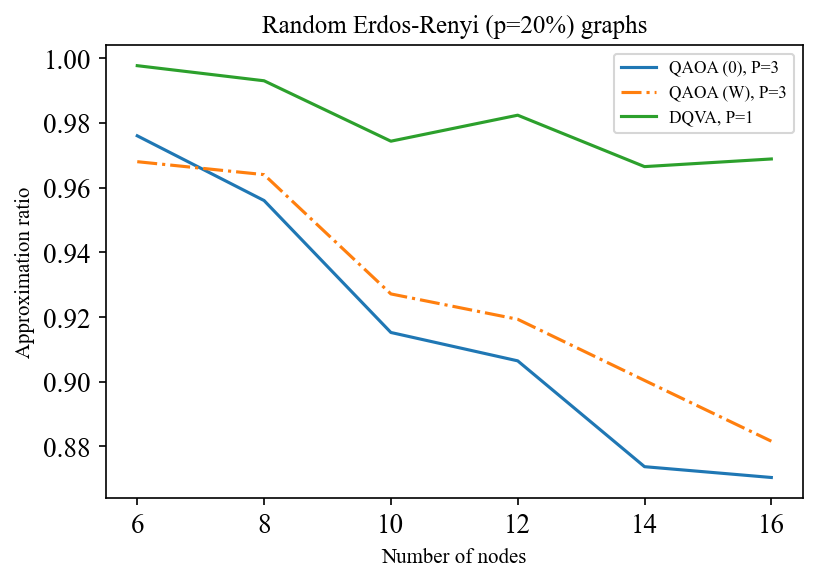

In [104]:
fig, ax = plt.subplots(dpi=150)

for sizes, approxs, label in data:
    if 'W' in label:
        ls = '-.'
    else:
        ls = '-'
    ax.plot(sizes, approxs, label=label, ls=ls)
    
ax.set_ylabel('Approximation ratio')
ax.set_xlabel('Number of nodes')
ax.set_title('Random Erdos-Renyi (p={}%) graphs'.format(d))
ax.legend(fontsize='small')
#plt.savefig('figures/dqva_erdosrenyi_p{}.png'.format(d))
plt.show()
plt.close()

In [46]:
mis_list = lists[0][1]
medians = [np.median(l) for l in mis_list]
print(medians)

[1.0, 0.9, 0.9099999999999999, 0.88, 0.8619047619047618, 0.875]


[-0.2        -0.06666667  0.06666667  0.2       ]
QAOA (0), P=1
QAOA (0), P=3
QAOA (W), P=1
QAOA (W), P=3


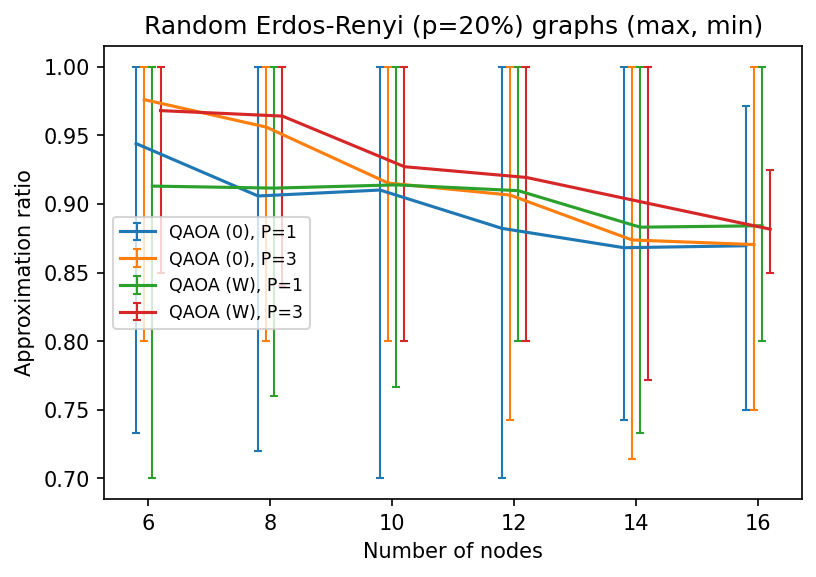

In [70]:
fig, ax = plt.subplots(dpi=150)

offset = np.linspace(-0.2, 0.2, len(lists))
print(offset)

for i, (sizes, mis_list, label) in enumerate(lists):
    print(label)
    sizes = np.array(sizes) + offset[i]
    vals = [np.mean(l) for l in mis_list]
    upper_err = [abs(np.max(l) - z) for l, z in zip(mis_list, vals)]
    lower_err = [abs(np.min(l) - z) for l, z in zip(mis_list, vals)]
    #print(vals)
    #print(upper_err)
    #print(lower_err)
    ax.errorbar(sizes, vals, yerr=[lower_err, upper_err], label=label, elinewidth=1, capsize=2)
    
ax.set_ylabel('Approximation ratio')
ax.set_xlabel('Number of nodes')
ax.set_title('Random Erdos-Renyi (p={}%) graphs (max, min)'.format(d))
ax.legend(fontsize='small')
plt.show()
plt.close()

QAOA (0), P=3
QAOA (W), P=3
DQVA, P=1


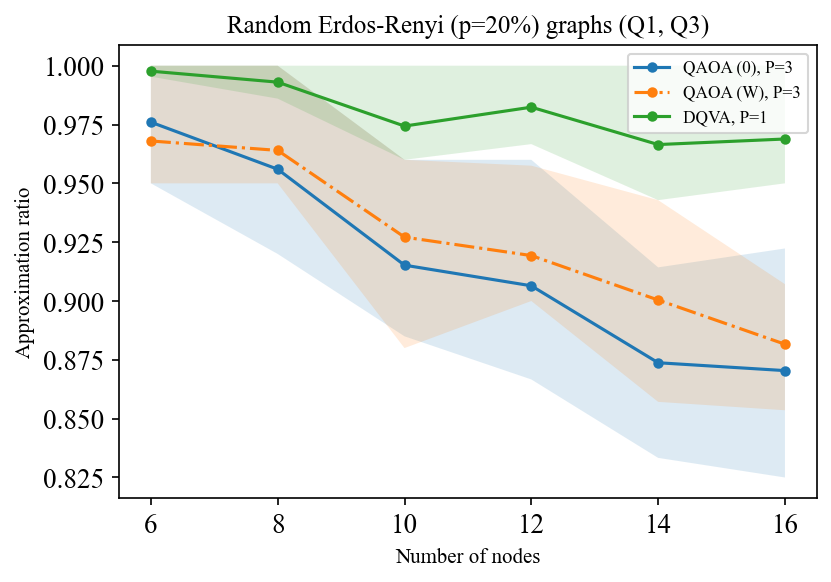

In [105]:
fig, ax = plt.subplots(dpi=150)

#offset = np.linspace(-0.2, 0.2, len(lists))
#print(offset)

for i, (sizes, mis_list, label) in enumerate(lists):
    print(label)
    if 'W' in label:
        ls='-.'
    else:
        ls='-'
    #sizes = np.array(sizes) + offset[i]
    vals = [np.mean(l) for l in mis_list]
    upper_err = [abs(np.quantile(l, 0.75) - z) for l, z in zip(mis_list, vals)]
    lower_err = [abs(np.quantile(l, 0.25) - z) for l, z in zip(mis_list, vals)]
    #print(vals)
    #print(upper_err)
    #print(lower_err)
    #ax.errorbar(sizes, vals, yerr=[lower_err, upper_err], label=label, elinewidth=1, capsize=2)
    ax.errorbar(sizes, vals, label=label, fmt='-o', ls=ls, ms=4)
    
    y1 = [m+s for m, s in zip(vals, upper_err)]
    y2 = [m-s for m, s in zip(vals, lower_err)]
    ax.fill_between(sizes, y1, y2, alpha=0.15)
    
ax.set_ylabel('Approximation ratio')
ax.set_xlabel('Number of nodes')
ax.set_title('Random Erdos-Renyi (p={}%) graphs (Q1, Q3)'.format(d))
ax.legend(fontsize='small')
plt.show()
plt.close()

QAOA (0), P=1
QAOA (0), P=3
QAOA (W), P=1
QAOA (W), P=3


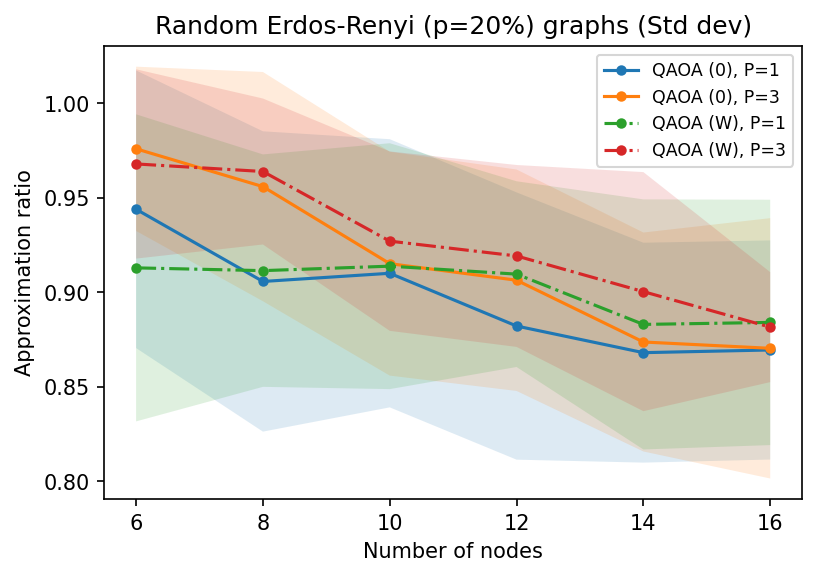

In [68]:
fig, ax = plt.subplots(dpi=150)

#offset = np.linspace(-0.2, 0.2, len(lists))
#print(offset)

for i, (sizes, mis_list, label) in enumerate(lists):
    print(label)
    if 'W' in label:
        ls='-.'
    else:
        ls='-'
    #sizes = np.array(sizes) + offset[i]
    vals = [np.mean(l) for l in mis_list]
    upper_err = [abs(np.std(l)) for l, z in zip(mis_list, vals)]
    lower_err = [abs(np.std(l)) for l, z in zip(mis_list, vals)]
    #print(vals)
    #print(upper_err)
    #print(lower_err)
    #ax.errorbar(sizes, vals, yerr=[lower_err, upper_err], label=label, elinewidth=1, capsize=2)
    ax.errorbar(sizes, vals, label=label, fmt='-o', ls=ls, ms=4)
    
    y1 = [m+s for m, s in zip(vals, upper_err)]
    y2 = [m-s for m, s in zip(vals, lower_err)]
    ax.fill_between(sizes, y1, y2, alpha=0.15)
    
ax.set_ylabel('Approximation ratio')
ax.set_xlabel('Number of nodes')
ax.set_title('Random Erdos-Renyi (p={}%) graphs (Std dev)'.format(d))
ax.legend(fontsize='small')
plt.show()
plt.close()

['P1_p20', 'P1_p40', 'P1_p60']
['P4_p20', 'P4_p40', 'P4_p60']
['P8_p20', 'P8_p40', 'P8_p60']
['P1_p20', 'P1_p40', 'P1_p60']
['P4_p20', 'P4_p40', 'P4_p60']
['P8_p20', 'P8_p40', 'P8_p60']


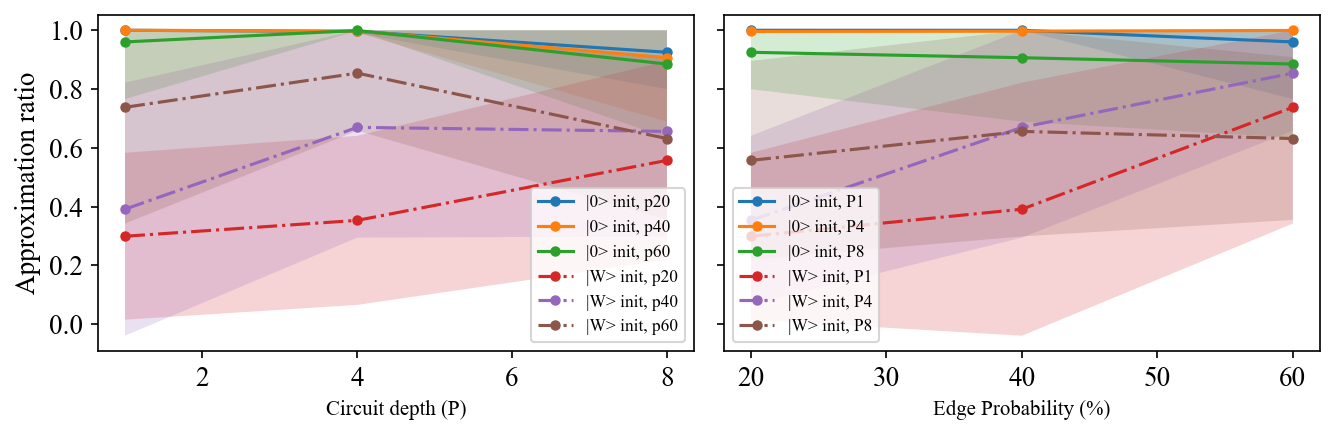

In [60]:
fig, ax = plt.subplots(dpi=150, figsize=[9,3], nrows=1, ncols=2, sharey='row')

dataval = 3

# Axis 0
qaoa0_20 = [(key, qaoa0_data[key]['mis'], qaoa0_data[key]['list'], qaoa0_data[key]['opt_probs']) for key in qaoa0_data.keys() if '20' in key]
qaoa0_40 = [(key, qaoa0_data[key]['mis'], qaoa0_data[key]['list'], qaoa0_data[key]['opt_probs']) for key in qaoa0_data.keys() if '40' in key]
qaoa0_60 = [(key, qaoa0_data[key]['mis'], qaoa0_data[key]['list'], qaoa0_data[key]['opt_probs']) for key in qaoa0_data.keys() if '60' in key]
all_qaoa0 = [qaoa0_20, qaoa0_40, qaoa0_60]

qaoaW_20 = [(key, qaoaW_data[key]['mis'], qaoaW_data[key]['list'], qaoaW_data[key]['opt_probs']) for key in qaoaW_data.keys() if '20' in key]
qaoaW_40 = [(key, qaoaW_data[key]['mis'], qaoaW_data[key]['list'], qaoaW_data[key]['opt_probs']) for key in qaoaW_data.keys() if '40' in key]
qaoaW_60 = [(key, qaoaW_data[key]['mis'], qaoaW_data[key]['list'], qaoaW_data[key]['opt_probs']) for key in qaoaW_data.keys() if '60' in key]
all_qaoaW = [qaoaW_20, qaoaW_40, qaoaW_60]

allowlist = ['p20', 'p40', 'p60']
for data_set, ls, labelstr in zip([all_qaoa0, all_qaoaW], ['-', '-.'], ['|0> init', '|W> init']):
    for dat in data_set:
        if len(dat) == 0:
            continue
            
        pval = dat[0][0].split('_')[1]
        if not pval in allowlist:
            continue
            
        sizes = [int(v[0].split('_')[0].strip('P')) for v in dat]
        means = [np.mean(v[dataval]) for v in dat]
        lists = [v[dataval] for v in dat]

        #upper_err = [abs(np.quantile(l, 0.75) - z) for l, z in zip(lists, means)]
        #lower_err = [abs(np.quantile(l, 0.25) - z) for l, z in zip(lists, means)]
        upper_err = [np.std(l) for l in lists]
        lower_err = [np.std(l) for l in lists]

        ls = ls
        label = labelstr + ', ' + pval
        ax[0].errorbar(sizes, means, label=label, fmt='-o', ls=ls, ms=4)

        y1 = [min(m+s, 1) for m, s in zip(means, upper_err)]
        y2 = [m-s for m, s in zip(means, lower_err)]
        ax[0].fill_between(sizes, y1, y2, alpha=0.2)

# Axis 1
qaoa0_1 = [(key, qaoa0_data[key]['mis'], qaoa0_data[key]['list'], qaoa0_data[key]['opt_probs']) for key in qaoa0_data.keys() if 'P1' in key]
qaoa0_4 = [(key, qaoa0_data[key]['mis'], qaoa0_data[key]['list'], qaoa0_data[key]['opt_probs']) for key in qaoa0_data.keys() if 'P4' in key]
qaoa0_8 = [(key, qaoa0_data[key]['mis'], qaoa0_data[key]['list'], qaoa0_data[key]['opt_probs']) for key in qaoa0_data.keys() if 'P8' in key]
all_qaoa0 = [qaoa0_1, qaoa0_4, qaoa0_8]

qaoaW_1 = [(key, qaoaW_data[key]['mis'], qaoaW_data[key]['list'], qaoaW_data[key]['opt_probs']) for key in qaoaW_data.keys() if 'P1' in key]
qaoaW_4 = [(key, qaoaW_data[key]['mis'], qaoaW_data[key]['list'], qaoaW_data[key]['opt_probs']) for key in qaoaW_data.keys() if 'P4' in key]
qaoaW_8 = [(key, qaoaW_data[key]['mis'], qaoaW_data[key]['list'], qaoaW_data[key]['opt_probs']) for key in qaoaW_data.keys() if 'P8' in key]
all_qaoaW = [qaoaW_1, qaoaW_4, qaoaW_8]

allowlist = ['P1',  'P4', 'P8']
for data_set, ls, labelstr in zip([all_qaoa0, all_qaoaW], ['-', '-.'], ['|0> init', '|W> init']):
    for dat in data_set:
        print([v[0] for v in dat])
    for dat in data_set:
        if len(dat) == 0:
            continue
        
        pval = dat[0][0].split('_')[0]
        if not pval in allowlist:
            continue
            
        sizes = [int(v[0].split('_')[1].strip('p')) for v in dat]
        means = [np.mean(v[dataval]) for v in dat]
        lists = [v[dataval] for v in dat]

        #upper_err = [abs(np.quantile(l, 0.75) - z) for l, z in zip(lists, means)]
        #lower_err = [abs(np.quantile(l, 0.25) - z) for l, z in zip(lists, means)]
        upper_err = [np.std(l) for l in lists]
        lower_err = [np.std(l) for l in lists]

        ls = ls
        label = labelstr + ', ' + pval
        ax[1].errorbar(sizes, means, label=label, fmt='-o', ls=ls, ms=4)

        y1 = [min(m+s, 1) for m, s in zip(means, upper_err)]
        y2 = [m-s for m, s in zip(means, lower_err)]
        ax[1].fill_between(sizes, y1, y2, alpha=0.2)

    
ax[0].set_ylabel('Approximation ratio', fontsize=13)
ax[0].set_xlabel('Circuit depth (P)')
ax[1].set_xlabel('Edge Probability (%)')
#fig.suptitle('Random p={}% Erdos-Renyi graphs (Q1, Q3)'.format(d), fontsize=14)
ax[0].legend(fontsize='small', loc='lower right')
ax[1].legend(fontsize='small', loc='lower left')
plt.tight_layout()
#plt.savefig('figures/qaoansatz_erdosrenyi_p{}.png'.format(d))
plt.show()
plt.close()

['P1_p20', 'P1_p40', 'P1_p60']
['P4_p20', 'P4_p40', 'P4_p60']
['P8_p20', 'P8_p40', 'P8_p60']
['P1_p20', 'P1_p40', 'P1_p60']
['P4_p20', 'P4_p40', 'P4_p60']
['P8_p20', 'P8_p40', 'P8_p60']
['P1_p20', 'P1_p40', 'P1_p60']


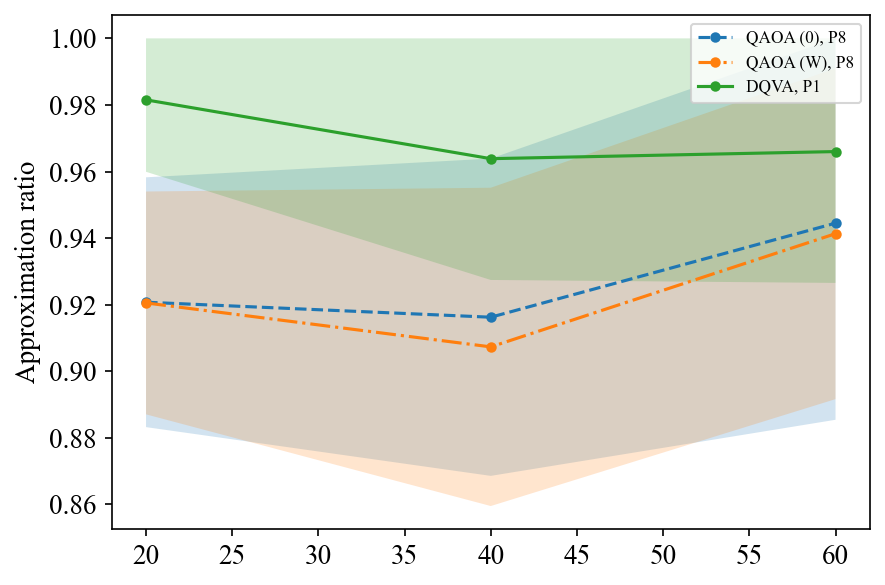

In [15]:
fig, ax = plt.subplots(dpi=150)

qaoa0_1 = [(key, qaoa0_data[key]['mis'], qaoa0_data[key]['list']) for key in qaoa0_data.keys() if 'P1' in key]
qaoa0_4 = [(key, qaoa0_data[key]['mis'], qaoa0_data[key]['list']) for key in qaoa0_data.keys() if 'P4' in key]
qaoa0_8 = [(key, qaoa0_data[key]['mis'], qaoa0_data[key]['list']) for key in qaoa0_data.keys() if 'P8' in key]
all_qaoa0 = [qaoa0_1, qaoa0_4, qaoa0_8]

qaoaW_1 = [(key, qaoaW_data[key]['mis'], qaoaW_data[key]['list']) for key in qaoaW_data.keys() if 'P1' in key]
qaoaW_4 = [(key, qaoaW_data[key]['mis'], qaoaW_data[key]['list']) for key in qaoaW_data.keys() if 'P4' in key]
qaoaW_8 = [(key, qaoaW_data[key]['mis'], qaoaW_data[key]['list']) for key in qaoaW_data.keys() if 'P8' in key]
all_qaoaW = [qaoaW_1, qaoaW_4, qaoaW_8]

all_dqva = [[(key, dqva_data[key]['mis'], dqva_data[key]['list']) for key in dqva_data.keys()]]

allowlist = ['DQVA_P1', 'QAOA (0)_P8', 'QAOA (W)_P8']
for data_set, ls, labelstr in zip([all_qaoa0, all_qaoaW, all_dqva], ['--', '-.', '-'], ['QAOA (0)', 'QAOA (W)', 'DQVA']):
    for dat in data_set:
        print([v[0] for v in dat])
    for dat in data_set:
        if len(dat) == 0:
            continue
        
        pval = dat[0][0].split('_')[0]
        if not labelstr+'_'+pval in allowlist:
            continue
            
        sizes = [int(v[0].split('_')[1].strip('p')) for v in dat]
        means = [v[1] for v in dat]
        lists = [v[2] for v in dat]

        #upper_err = [abs(np.quantile(l, 0.75) - z) for l, z in zip(lists, means)]
        #lower_err = [abs(np.quantile(l, 0.25) - z) for l, z in zip(lists, means)]
        upper_err = [np.std(l) for l in lists]
        lower_err = [np.std(l) for l in lists]

        ls = ls
        label = labelstr + ', ' + pval
        ax.errorbar(sizes, means, label=label, fmt='-o', ls=ls, ms=4)

        y1 = [min(m+s, 1) for m, s in zip(means, upper_err)]
        y2 = [m-s for m, s in zip(means, lower_err)]
        ax.fill_between(sizes, y1, y2, alpha=0.2)

    
ax.set_ylabel('Approximation ratio', fontsize=13)
ax.legend(fontsize='small')
plt.tight_layout()
#plt.savefig('figures/dqva_erdosrenyi.png'.format(d))
plt.show()
plt.close()

# Do DQVA and QLS improve in later rounds?

In [106]:
def get_pickles(alg, P, sim, n, d, lim=None):
    
    retval = []
    
    base_path = 'benchmark_results/{}_P{}_{}/'.format(alg, P, sim)
    if d < 10:
        graph_paths = 'N*_d{}_graphs/'.format(d)
    else:
        graph_paths = 'N*_p{}_graphs/'.format(d)
    
    graph_dirs = glob.glob(base_path + graph_paths)
    graph_dirs = sorted(graph_dirs, key=lambda fn: int(fn.split('/')[-2].split('_')[0].strip('N')))
    
    for gd in graph_dirs:
        #print(gd)
        all_graphs = glob.glob(gd+'*')
        temp_mis_approx = []
        for graph in all_graphs:
            #print('\t', graph)
            graphfn = 'benchmark_graphs/' + '/'.join(graph.split('/')[-2:]) + '.txt'
            G = graph_from_file(graphfn)
            
            temp_name = graph.split('/')[-2:]
            graph_name = temp_name[0].strip('graphs') + temp_name[1]
            
            opt = brute_force_search(G)[1]
            #print('\t Opt =', opt)
            if alg == 'qlsa' and d > 10:
                if lim is None:
                    raise Exception('Must specify lim parameter with alg=qlsa')
                reps = glob.glob(graph+'/*_lim{}_*'.format(lim))
            else:
                reps = glob.glob(graph+'/*')
            temp_pickles = []
            for pklfile in reps:
                #print('\t\t', pklfile)
                with open(pklfile, 'rb') as pf:
                    res = pickle.load(pf)
                    #print('\t'*3, res['graph'])
                    #print('\t'*3, res['out'][0])
                    temp_pickles.append(res['out'])
        
            # after collecting reps for this graph, store the results
            retval.append((G, opt, temp_pickles, graph_name))
            
    return retval

In [107]:
def plot_qls_approxs(data, savedir=None, show=True, verbose=0):
    
    G, opt, outs, graph_name = data
    print(graph_name)
    print('Opt =', opt)
    
    fig, ax = plt.subplots(dpi=150)

    for r, out in enumerate(outs):
        best_mis, best_params, best_init, best_mixer, history = out
        if verbose > 0:
            print('\nRep', r + 1)
            print(best_mis, best_init, best_mixer, len(history))
        num_mixer_rounds = len(history)
        x_vals, y_vals = [], []
        for i, mixer_round in enumerate(history):
            num_inner_rounds = len(mixer_round)

            for j, inner_round in enumerate(mixer_round):
                x_vals.append(i+1 + j/(num_inner_rounds+1))
                y_vals.append(abs(inner_round['cost'] / opt))
                if verbose > 0:
                    print('\t Mixer={}, Inner={}'.format(i+1, j+1))
                    print('\t', inner_round)

        ax.plot(x_vals, y_vals, c='b', alpha=0.2)
        ax.scatter(x_vals, y_vals, c='b', alpha=0.2, s=20)

    for i in range(1, num_mixer_rounds+1):
        ax.axvline(x=i, c='k', ls='--', alpha=0.3)

    ax.set_title('DQVA MIS approximations for Graph {}'.format(graph_name))
    ax.set_ylabel('Approximation Ratio')
    ax.set_xlabel('Mixer & Inner Rounds')
    
    if not savedir is None:
        if savedir[-1] != '/':
            savedir += '/'
        plt.savefig(savedir + graph_name + '.png')
        
    if show:
        plt.show()
    plt.close()

In [108]:
dqva_N14_p20_data = get_pickles('dqva', 1, 'qasm', 14, 20, lim=None)
g1_data = dqva_N14_p20_data[0]

N6_p20_G22
Opt = 3


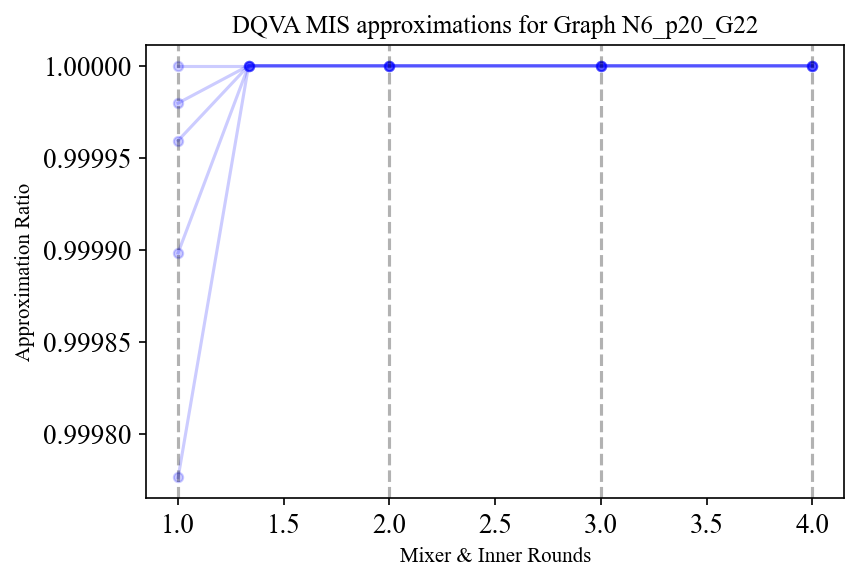

In [131]:
g1_data = dqva_N14_p20_data[22]
plot_qls_approxs(g1_data, verbose=0)

In [56]:
# Plot and save all of the qls results
for N in [6, 8, 10, 12, 14, 16]:
    for d in [20, 30, 50, 80]:
        for lim in [2, 4, 6]:
            qlsa_data = get_pickles('qlsa', 1, 'qasm', N, d, lim=lim)
            for data in qlsa_data:
                plot_qlsa_approxs(data, savedir='figures/qlsa_approximations/lim{}/'.format(lim), show=False)

N6_p20_G31
Opt = 4
N6_p20_G36
Opt = 3
N6_p20_G38
Opt = 4
N6_p20_G6
Opt = 3
N6_p20_G1
Opt = 3
N6_p20_G8
Opt = 3
N6_p20_G39
Opt = 3
N6_p20_G37
Opt = 3
N6_p20_G30
Opt = 3
N6_p20_G9
Opt = 3
N6_p20_G7
Opt = 3
N6_p20_G48
Opt = 3
N6_p20_G41
Opt = 3
N6_p20_G46
Opt = 3
N6_p20_G12
Opt = 3
N6_p20_G15
Opt = 3
N6_p20_G23
Opt = 3
N6_p20_G24
Opt = 3
N6_p20_G47
Opt = 3
N6_p20_G40
Opt = 3
N6_p20_G49
Opt = 4
N6_p20_G25
Opt = 3
N6_p20_G22
Opt = 3
N6_p20_G14
Opt = 3
N6_p20_G13
Opt = 4
N6_p20_G2
Opt = 3
N6_p20_G50
Opt = 3
N6_p20_G5
Opt = 3
N6_p20_G35
Opt = 4
N6_p20_G32
Opt = 3
N6_p20_G4
Opt = 4
N6_p20_G3
Opt = 3
N6_p20_G33
Opt = 4
N6_p20_G34
Opt = 3
N6_p20_G16
Opt = 4
N6_p20_G29
Opt = 3
N6_p20_G11
Opt = 3
N6_p20_G27
Opt = 3
N6_p20_G18
Opt = 4
N6_p20_G20
Opt = 3
N6_p20_G45
Opt = 3
N6_p20_G42
Opt = 3
N6_p20_G21
Opt = 4
N6_p20_G26
Opt = 4
N6_p20_G19
Opt = 4
N6_p20_G10
Opt = 3
N6_p20_G17
Opt = 3
N6_p20_G28
Opt = 3
N6_p20_G43
Opt = 3
N6_p20_G44
Opt = 4
N8_p20_G31
Opt = 4
N8_p20_G36
Opt = 4
N8_p20_G38
Opt = 4
N8

KeyboardInterrupt: 

<Figure size 900x600 with 0 Axes>

In [136]:
np.random.uniform(low=0.0, high=2*np.pi, size=6)

array([6.13745412, 2.77906319, 3.52945028, 5.25463717, 5.68995764,
       3.78676132])